In [213]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

headers = ['user_id', 'movie_id', 'rating', 'time']
data = pd.read_table('ml-100k/u.data', sep='\t', header=None, names=headers)

In [32]:
data.head()

,user_id,movie_id,rating,time
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [172]:
user = data['user_id'].values
movie = data['movie_id'].values
rating = data['rating'].values

In [173]:
def build_R(user, movie, rating):
    R = np.zeros((943,1682),dtype=int)
    for i in range(len(user)):
        R[user[i]-1, movie[i]-1] = rating[i]
    return R

In [198]:
R = build_R(user, movie, rating)
W = (R!=0)
W[W == True] = 1
W[W == False] = 0
# To be consistent with our Q matrix
W = W.astype(np.float64, copy=False)
W

array([[ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]])

In [6]:
def get_error(R, U, V, W):
    return np.sum((W * (R - np.dot(U, V))**2))

In [199]:
print R.shape
R

(943, 1682)


array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]])

# Part 1 (No Cross Validation)

('min error:', 518682.62841141428)


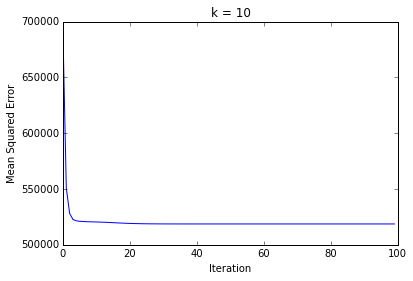

('min error:', 344321.48484513257)


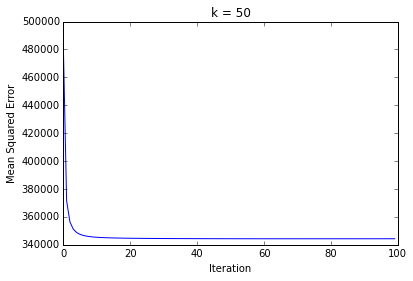

('min error:', 228771.95513621415)


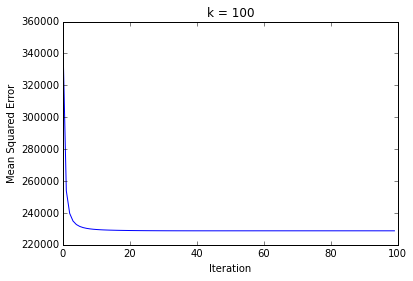

('min error:', 7328.5006101953968)


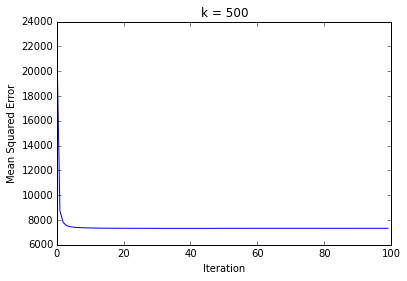

In [8]:
m, n = R.shape
n_iterations = 100
min_error = np.inf
for k in (10, 50, 100, 500):
    U = 5 * np.random.rand(m, k)
    V = 5 * np.random.rand(k, n)
    errors = []
    for it in range(n_iterations):
        U = np.linalg.solve(np.dot(V, V.T), np.dot(V, R.T)).T
        V = np.linalg.solve(np.dot(U.T, U), np.dot(U.T, R)) 
        error = get_error(R, U, V, W)                
        errors.append(error)
        
        # find the R_hat with min error
        if error<min_error:
            min_error = error
            R_hat = np.dot(U, V)

    print("min error:", min_error)
    plt.plot(errors)
    plt.title("k = %d" % k)
    plt.ylabel("Mean Squared Error")
    plt.xlabel("Iteration")
    plt.show()

In [9]:
R_hat-=np.min(R_hat)
R_hat *= float(5) / np.max(R_hat)
R_hat

array([[ 4.6685711 ,  3.09151157,  3.79704864, ...,  0.67870268,
         0.67237972,  0.70181976],
       [ 3.84779138,  0.74279844,  0.9081698 , ...,  0.65855347,
         0.70184005,  0.7114051 ],
       [ 0.70167886,  0.74914972,  0.718823  , ...,  0.72389392,
         0.71574997,  0.6606244 ],
       ..., 
       [ 4.63974204,  0.66136223,  0.67457705, ...,  0.69266462,
         0.68256109,  0.69085666],
       [ 0.70527442,  0.95854795,  0.7553875 , ...,  0.68134905,
         0.69411845,  0.67493008],
       [ 0.6581675 ,  4.55757412,  0.80506508, ...,  0.71564836,
         0.73029981,  0.67570742]])

# Part 2 (Cross Validation)

In [92]:
# from sklearn.model_selection import KFold

# def validation_error(test_user, test_movie, R, test_rating):
#     error = 0
#     for i in range(len(test_user)):
#         error += np.absolute(test_rating[i]-R[test_user[i]-1, test_movie[i]-1])
#     return error

# # 10-fold cross validation
# m, n = R.shape
# n_iterations = 100
# kf = KFold(n_splits=10)

# for k in (10, 50, 100, 500):
#     count = 1
#     v_errors = []
#     for train, test in kf.split(user):
#         train_user = user[train]
#         train_movie = movie[train]
#         train_rating = rating[train]
#         test_user = user[test]
#         test_movie = movie[test]
#         test_rating = rating[test]

#         R = build_R(train_user, train_movie, train_rating)
#         W = (R!=0)
#         W[W == True] = 1
#         W[W == False] = 0
#         W = W.astype(np.float64, copy=False)

#         U = 5 * np.random.rand(m, k) 
#         V = 5 * np.random.rand(k, n)
#         errors = []
#         min_error = np.inf
#         for it in range(n_iterations):
#             U = np.linalg.solve(np.dot(V, V.T), np.dot(V, R.T)).T
#             V = np.linalg.solve(np.dot(U.T, U), np.dot(U.T, R)) 
#             error = get_error(R, U, V, W)                
#             errors.append(error)
#             if error<min_error:
#                 min_error = error
#                 min_test = test
#                 R_hat = np.dot(U, V)

#         R_hat -= np.min(R_hat)
#         R_hat *= float(5) / np.max(R_hat)
#         v_error = validation_error(test_user, test_movie, R_hat, test_rating)
#         print("k=%d, average error of test %d:%f"%(k, count, v_error/len(test_user)))
#         v_errors.append(v_error)
#         count += 1
#     print("average error of k=%d system:%f"%(k, sum(v_errors)/10))
    

In [76]:
from sklearn.model_selection import KFold

def validation_error(test_user, test_movie, R, test_rating):
    error = 0
    for i in range(len(test_user)):
        error += np.absolute(test_rating[i]-R[test_user[i]-1, test_movie[i]-1])
    return error

# 10-fold cross validation
m, n = R.shape
n_iterations = 100
kf = KFold(n_splits=10, shuffle=True, random_state=50)

for k in (10, 50, 100, 500):
    count = 1
    v_errors = []
    for train_index,test_index in kf.split(data):
        train = data.as_matrix()[train_index]
        test = data.as_matrix()[test_index]
        W = (R!=0)
        W[W == True] = 1
        W[W == False] = 0
        # To be consistent with our Q matrix
        W = W.astype(np.float64, copy=False)

        for i in range(len(train_index)):
            W[train[i][0] - 1, train[i][1] - 1] = 1

        U = 5 * np.random.rand(m, k) 
        V = 5 * np.random.rand(k, n)
        errors = []
        min_error = np.inf
        for it in range(n_iterations):
            U = np.linalg.solve(np.dot(V, V.T), np.dot(V, R.T)).T
            V = np.linalg.solve(np.dot(U.T, U), np.dot(U.T, R)) 
            error = get_error(R, U, V, W)                
            errors.append(error)
            if error<min_error:
                min_error = error
                min_test = test
                R_hat = np.dot(U, V)

        R_hat -= np.min(R_hat)
        R_hat *= float(5) / np.max(R_hat)
        
        v_error = 0
        for j in range(len(test_index)):
            v_error += np.absolute(test[j][2]-R_hat[test[j][0]-1, test[j][1]-1])
        
#         v_error = validation_error(test_user, test_movie, R_hat, test_rating)
        print("k=%d, average error of test %d:%f"%(k, count, v_error/len(test_index)))
        v_errors.append(v_error)
        count += 1
        print("average error of k=%d system:%f"%(k, sum(v_errors)/10))
    
    
 

k=10, average error of test 1:1.858030
average error of k=10 system:1858.029846
k=10, average error of test 2:1.877288
average error of k=10 system:3735.317615
k=10, average error of test 3:1.852146
average error of k=10 system:5587.463955
k=10, average error of test 4:1.845032
average error of k=10 system:7432.495797
k=10, average error of test 5:1.857828
average error of k=10 system:9290.323799
k=10, average error of test 6:1.856006
average error of k=10 system:11146.329780
k=10, average error of test 7:1.850142
average error of k=10 system:12996.471931
k=10, average error of test 8:1.877411
average error of k=10 system:14873.883178
k=10, average error of test 9:1.852948
average error of k=10 system:16726.831465
k=10, average error of test 10:1.854741
average error of k=10 system:18581.572891
k=50, average error of test 1:1.420244
average error of k=50 system:1420.243582
k=50, average error of test 2:1.460113
average error of k=50 system:2880.356760
k=50, average error of test 3:1.44

In [229]:
def plot_roc(r_hat, r, k, lmbda):
    tp = 0  # true positive
    fp = 0  # false positive
    fn = 0  # false negative

    threshold_value = np.arange(1,6,1)
    precision = np.zeros(len(threshold_value))
    recall = np.zeros(len(threshold_value))

    for i, t in enumerate(threshold_value):
        tp = np.sum(r[r_hat >= t] >= t)
        fp = np.sum(r[r_hat >= t] < t)
        fn = np.sum(r[r_hat < t] >= t)

        precision[i] = tp / float(tp+fp)  # calculating precision
        recall[i] = tp / float(tp+fn)  # calculating recall

    plt.figure(1)
    plt.ylabel('Recall')
    plt.xlabel('Precision')
    plt.title('ROC Curve k={0} lambda={1}'.format(k,lmbda))
    plt.scatter(precision, recall, s=60, marker='o')
    plt.plot(precision,recall)
    plt.show()

# Part 4 - interchange weight/rating matrix

In [18]:
W_1 = R.copy()
R_1 = W.copy()

In [212]:
m, n = R_1.shape
n_iterations = 100
min_error = np.inf
lmbda = 0.1
for k in (10, 50, 100, 500):
    U = 5 * np.random.rand(m, k)
    V = 5 * np.random.rand(k, n)
    errors = []
    for it in range(n_iterations):
        U = np.linalg.solve(np.dot(V, V.T), np.dot(V, R_1.T)).T
        V = np.linalg.solve(np.dot(U.T, U), np.dot(U.T, R_1)) 
        error = get_error(R_1, U, V, W_1)                
        errors.append(error)
        
        # find the R_hat with min error
        if error<min_error:
            min_error = error
            R_hat = np.dot(U, V)

    print ("Leasted Squared error when K = %d: %f"%(k, min_error))
#     plt.plot(errors)
#     plt.title("k = %d" % k)
#     plt.ylabel("Mean Squared Error")
#     plt.xlabel("Iteration")
#     plt.show()

Leasted Squared error when K = 10: 128481.586294
Leasted Squared error when K = 50: 86853.134640
Leasted Squared error when K = 100: 59135.867432
Leasted Squared error when K = 500: 2067.973426


# Part 4 - add regularization

error for k = 10, lambda = 0.01: 520082.689854


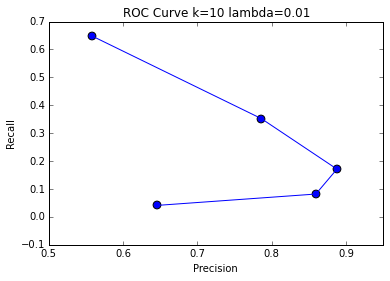

error for k = 10, lambda = 0.10: 520667.313129


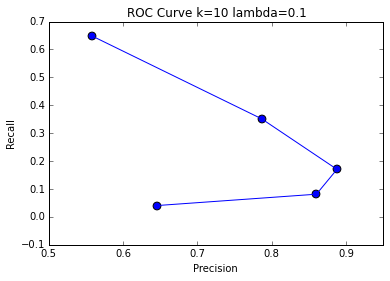

error for k = 10, lambda = 1.00: 521139.617664


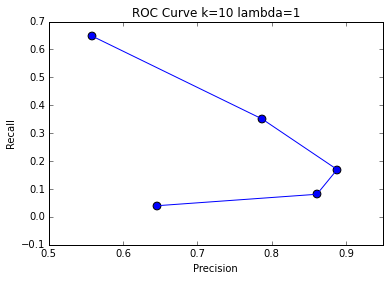

error for k = 50, lambda = 0.01: 345510.355677


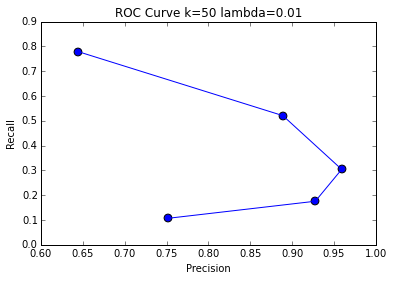

error for k = 50, lambda = 0.10: 346093.448286


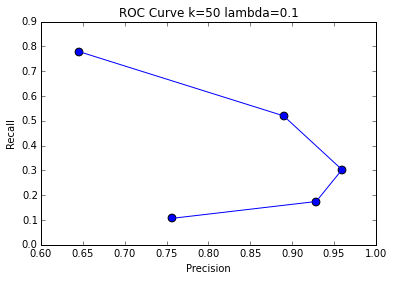

error for k = 50, lambda = 1.00: 347389.179082


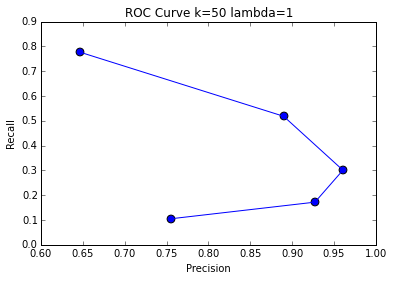

error for k = 100, lambda = 0.01: 229884.253657


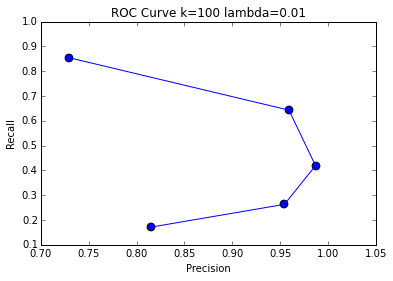

error for k = 100, lambda = 0.10: 230289.832031


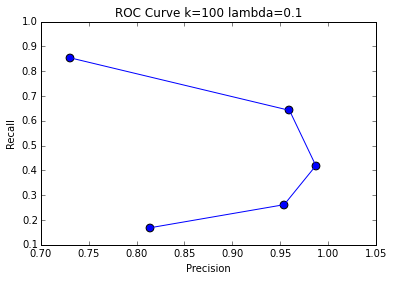

error for k = 100, lambda = 1.00: 232216.165217


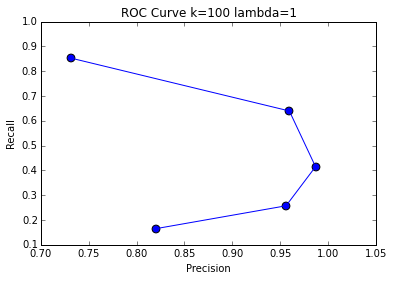

In [230]:
m, n = R.shape
n_iterations = 100
min_error = np.inf
for k in (10, 50, 100):
    for lmbda in (0.01, 0.1, 1):
        U = 5 * np.random.rand(m, k)
        V = 5 * np.random.rand(k, n)
        errors = []
        for it in range(n_iterations):
            U = np.linalg.solve(np.dot(V, V.T) + lmbda * np.eye(k), np.dot(V, R.T)).T
            V = np.linalg.solve(np.dot(U.T, U) + lmbda * np.eye(k), np.dot(U.T, R)) 
            error = get_error(R, U, V, W)                
            errors.append(error)

            # find the R_hat with min error
#             if error<min_error:
#                 min_error = error
#                 R_hat = np.dot(U, V)
        R_hat = np.dot(U, V)
        print("error for k = %d, lambda = %.2f: %f"%(k, lmbda, error))
        
        # plot roc curve
        plot_roc(R_hat, R, k, lmbda)

# Part 5

In [233]:
# 10-fold cross validation
m, n = R.shape
n_iterations = 100
kf = KFold(n_splits=10, shuffle=True, random_state=50)
k = 100
lmbda = 0.01

count = 1
v_errors = []
L = 5
threshold = 3
top_movies = []
hit_cross_val = []
alarm_cross_val = []
total_cross_val = []
precision_cross_val = []

for train_index,test_index in kf.split(data):
    test = data.as_matrix()[test_index]
    
    R_train = W.copy()
    W_train = R.copy()

    # set to 0 if data point is in test set
    for i in range(len(test_index)):
        W_train[test[i][0] - 1, test[i][1] - 1] = 0

    U = 5 * np.random.rand(m, k) 
    V = 5 * np.random.rand(k, n)
    errors = []
    min_error = np.inf
    for it in range(n_iterations):
        U = np.linalg.solve(np.dot(V, V.T) + lmbda * np.eye(k), np.dot(V, R_train.T)).T
        V = np.linalg.solve(np.dot(U.T, U) + lmbda * np.eye(k), np.dot(U.T, R_train)) 
        error = get_error(R_train, U, V, W_train)                
        errors.append(error)
        if error<min_error:
            min_error = error
            min_test = test
            R_hat = np.dot(U, V)

    R_hat -= np.min(R_hat)
    R_hat *= float(5) / np.max(R_hat)
    
    # ignore entries without actual rating
    R_hat[R_train == 0] = -1 
    
#     for j in range(m):
#         ratings = R_hat[j]
#         top_L = np.argsort(ratings)[:L]
#         top_movies.append(top_L)
    
    hit_val=[0,0,0,0,0]
    total_val=[0,0,0,0,0]
    alarm_val=[0,0,0,0,0]
    precision_val=[]
    
    for l in range(1,(L+1)):
        tp = 0
        fp = 0
        
        for i in range(m):
            
            movie_indices = np.argsort(R_hat[i])[-l:]
            for j in range(len(movie_indices)):
                pred_rating = R_hat[i][movie_indices[j]] # predicted rating
                act_rating = R[i][movie_indices[j]] # actual rating
                if pred_rating < 0:
                    continue
                if pred_rating > threshold: # predicted like
                    if act_rating > threshold:
                        hit_val[j] += 1
                        total_val[j] += 1
                        tp += 1
                    else:
                        fp += 1
                        alarm_val[j] += 1
                        total_val[j] += 1
#                 else: # predicted not like
#                     total_val[j] += 1 
#                     if act_rating > threshold:
#                         alarm_val[j] += 1
#                         total_val[j] += 1
        precision_val.append(tp / float(tp+fp))

    hit_cross_val.append(hit_val)
    alarm_cross_val.append(alarm_val)
    precision_cross_val.append(precision_val)
    total_cross_val.append(total_val)  
precision = np.sum(precision_cross_val,axis=0)
hits = np.sum(hit_cross_val,axis=0)
miss = np.sum(alarm_cross_val,axis=0)
total = np.sum(total_cross_val,axis=0)

hits = hits / (total.astype(float))
miss = miss / (total.astype(float))
precision = precision / 10.0   
    
print("Precision: {0}".format(precision))
print("Hits: {0}".format(hits))
print("Miss: {0}".format(miss))
 

[[4007, 3303, 2552, 1749, 895], [3919, 3234, 2505, 1724, 888], [3872, 3201, 2479, 1708, 880], [4144, 3388, 2595, 1768, 899], [4004, 3298, 2551, 1746, 894], [3919, 3235, 2506, 1723, 887], [4048, 3328, 2564, 1754, 898], [3896, 3220, 2491, 1713, 884], [3960, 3271, 2527, 1733, 887], [3953, 3260, 2521, 1731, 887]]
Precision: [ 0.72301666  0.71028271  0.70406829  0.70301212  0.69838939]
Hits: [ 0.69835356  0.70297514  0.70404492  0.71024267  0.72300258]
Miss: [ 0.30164644  0.29702486  0.29595508  0.28975733  0.27699742]


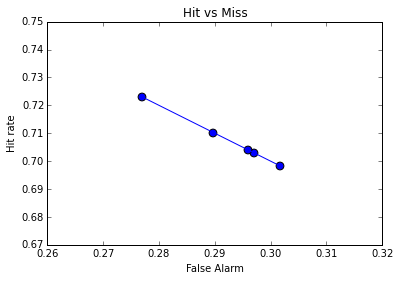

In [235]:
plt.figure(1)
plt.ylabel('Hit rate')
plt.xlabel('False Alarm')
plt.title('Hit vs Miss')
plt.scatter(miss, hits, s=60, marker='o')
plt.plot(miss,hits)
plt.show()